In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import seaborn as sns
from ExplainableMaximumLikelihoodCalculator import ExplainableMaximumLikelihoodCalculator
import pysam
from Bio import SeqIO, Seq, SeqRecord, pairwise2
from Bio.pairwise2 import format_alignment
from LoadDataUtils import getListOfReadsFromBamFile, getListOfReadsFromFastaFile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math
import shap
from scipy.stats import chisquare
from scipy.special import rel_entr
fileNameSapiens =  "data/simulatedData/human_chinese_AF346973_500samples.fas" #File that contains 500 reads from homo sapiens
fileNameNeanderthals =  "data/simulatedData/Neanderthal_Goyet_KX198085_500samples.fas" #File that contains 500 reads from neanderthal
fileNameDenisovans =  "data/simulatedData/denisova_kx663333_500samples.fas" #File that contains 500 reads from denisovan
neanderthals_500_generated = getListOfReadsFromFastaFile(fileNameNeanderthals)
sapiens_500_generated = getListOfReadsFromFastaFile(fileNameSapiens)
denisovan_500_samples = getListOfReadsFromFastaFile(fileNameDenisovans)
path_to_frequencies_table = "data/substitution_matrix.tsv"

2023-08-11 07:25:59.143540: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-11 07:25:59.422507: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-11 07:25:59.483351: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-11 07:26:00.489095: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
sapiens_reference_file_names = [
                    "data/reference_files/human_AF346981_French.fa",
                     "data/reference_files/human_AY195760_Korea.fa",
                      "data/reference_files/human_AY882416_Ethiopia.fa",
                      "data/reference_files/human_AY963586_Italian.fa",
                      "data/reference_files/human_AY195781_Caucasian.fa",
                      "data/reference_files/human_AY195757_Iraqi-Israeli.fa",
                      "data/reference_files/human_AY195749_NativeAmerican.fa"]
neanderthals_reference_file_names = [
                            "data/reference_files/neanderthal_mezmaiskaya1_FM865411.fa",
                           "data/reference_files/Neanderthal_Altai_KC879692.fa",
                           "data/reference_files/Neanderthal_Denisova11_full_mtDNA_KU131206.fa",
                           "data/reference_files/Neanderthal_Spy_94a_MG025538.fa",
                            "data/reference_files/Neanderthal_Vindija33.16_AM948965.fa",
                            "data/reference_files/Neanderthal_Vindija33.19_KJ533545.fa"]
denisovan_reference_file_names = [  
                        "data/reference_files/Denisova_MT576653.1.fa",
                        "data/reference_files/Denisova_MT576652.1.fa",
                        "data/reference_files/Denisova_4_FR695060.fa",
                        "data/reference_files/Denisova_8_KT780370.fa",
                        "data/reference_files/Denisova_manual_phalanx_NC_013993.fa",
                        "data/reference_files/Denisova_MT576651.1.fa"]

In [3]:
def generate_sample(sap, nean, den):
    list_before =  list(np.random.choice(sapiens_500_generated, sap)) + list(np.random.choice(neanderthals_500_generated, nean)) + list(np.random.choice(denisovan_500_samples, den))
    l = []
    for i in list_before:
        l.append(str(i))
    return l

In [4]:
sapiens = 5
neanderthals = 5
denisovans = 0

dataset_1 = generate_sample(sapiens, neanderthals, denisovans)

In [5]:
maximum_likelihood_calculator_d_1 = ExplainableMaximumLikelihoodCalculator(dataset_1,
                                                    ref_neanderthal_file_names=neanderthals_reference_file_names,
                                                    ref_sapien_file_names=sapiens_reference_file_names,
                                                    ref_denisovan_file_names=denisovan_reference_file_names,
                                                    path_to_substitution_matrix=path_to_frequencies_table,
                                                    number_of_jobs=-1)

Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  10
start working on read number 0


In [6]:
maximum_likelihood_calculator_d_1.estimate_species_proportions()

,Homo Sapiens,Neanderthals,Denisovans
Estimation,0.475,0.525,0.0


In [7]:
from itertools import combinations

def find_all_subsets(group):
    all_subsets = []
    n = len(group)
    
    for r in range(n + 1):
        subsets_r = combinations(group, r)
        all_subsets.extend(list(subsets_r))
        
    return all_subsets

In [8]:
def calculate_shapley_values_for_datum(data_point, length_of_data, ml_calculator):
    indexes_without_datum = [i for i in range(length_of_data) if i != data_point]
    all_subsets = find_all_subsets(indexes_without_datum)
    sum_over_all_subsets = 0 
    for G in all_subsets:
        g_with = [i for i in G]
        g_with.append(data_point)
        with_datum = ml_calculator.calc_maximum_likelihood_on_subset(subset_of_indexes=g_with).values[0]
        without_datum = ml_calculator.calc_maximum_likelihood_on_subset(subset_of_indexes=G).values[0]
        with_minus_without = with_datum - without_datum
        multiplier = np.math.factorial(len(G)) * np.math.factorial(length_of_data - len(G) - 1)
        value_for_sum = with_minus_without * multiplier 
        sum_over_all_subsets += value_for_sum
    shapleys = sum_over_all_subsets / np.math.factorial(length_of_data)
    return  shapleys

In [9]:
ground_truth_shapleys = []
for i in range(len(dataset_1)):
    print(i)
    ground_truth_shapleys.append(calculate_shapley_values_for_datum(i,len(dataset_1),maximum_likelihood_calculator_d_1))

0
1
2
3
4
5
6
7
8
9


1


  0%|          | 0/1 [00:00<?, ?it/s]

1
1022
Start working on read number 0 in processId 353
Start working on read number 1 in processId 354
Start working on read number 2 in processId 355
Start working on read number 3 in processId 356Start working on read number 4 in processId 357
Start working on read number 5 in processId 358
Start working on read number 6 in processId 359

Start working on read number 7 in processId 360
Start working on read number 8 in processId 355
Start working on read number 9 in processId 357


In [55]:
shapley_values_monte_carlo

[array([[ 0.    , -0.0388, -0.0285,  0.4634,  0.    , -0.2026,  0.0007,
         -0.2106,  0.004 ,  0.    ]]),
 array([[ 0.    ,  0.0388,  0.0285, -0.4634,  0.    ,  0.2026, -0.0007,
          0.2106, -0.004 ,  0.    ]]),
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])]

In [16]:
ground_truth_shapleys

[array([-0.0255    ,  0.07061111, -0.04511111]),
 array([-0.08596627,  0.01996627,  0.066     ]),
 array([-0.0830496 ,  0.12816071, -0.04511111]),
 array([ 0.5182004 , -0.47308929, -0.04511111]),
 array([-0.01111508,  0.05622619, -0.04511111]),
 array([-0.2142996 ,  0.25941071, -0.04511111]),
 array([-0.02897222,  0.07408333, -0.04511111]),
 array([-0.2142996 ,  0.25941071, -0.04511111]),
 array([ 0.12611706, -0.08100595, -0.04511111]),
 array([-0.01111508,  0.05622619, -0.04511111])]

In [48]:
shaps

[array([[-0.01194444, -0.09146825, -0.08813492,  0.51353175, -0.0234127 ,
         -0.21646825, -0.00555556, -0.21646825,  0.12019841, -0.01027778]]),
 array([[ 0.05461111,  0.2       ,  0.13080159, -0.47086508,  0.06607937,
          0.25913492,  0.04822222,  0.25913492, -0.07753175,  0.05294444]]),
 array([[-0.04266667,  0.044     , -0.04266667, -0.04266667, -0.04266667,
         -0.04266667, -0.04266667, -0.04266667, -0.04266667, -0.04266667]])]

In [47]:
a_s_d[0][0]

[0.16999989037650481,
 -0.06424012157879294,
 0.13140795756860968,
 0.6696065899022112,
 0.1699240034541737,
 -0.32939248933844206,
 0.0449861379546187,
 -0.3299514707569916,
 0.1773825495983548,
 0.16999751097076016]

In [36]:
shaps[2]

array([[-0.04266667,  0.044     , -0.04266667, -0.04266667, -0.04266667,
        -0.04266667, -0.04266667, -0.04266667, -0.04266667, -0.04266667]])

In [10]:
def accuracy_shap(shap_values, ground_truth):
    count_correct = 0
    count = 0
    for label in range(3):
        
        first_label_shaps = shaps[label][0]
        first_label_gt = [i[label] for i in ground_truth]
        for i in range(len(first_label_gt)):
            if(first_label_shaps[i] * first_label_gt[i] > 0):
                count_correct +=1
            count +=1
    return count_correct / count
    
    
    

In [11]:
def accuracy_a_d_s(a_d_s_values, ground_truth):
    count_correct = 0
    count = 0
    for label in range(3):
        first_label_a_d = a_d_s_values[label][0]
        first_label_gt = [i[label] for i in ground_truth]
        for i in range(len(first_label_gt)):
            if(first_label_a_d[i] * first_label_gt[i] > 0):
                count_correct +=1
            count +=1
    return count_correct / count
    

In [12]:
def accuracy_monte_carlo(monte_carlo_values, ground_truth):
    count_correct = 0
    count = 0
    for label in range(3):
        first_label_monte = monte_carlo_values[label][0]
        first_label_gt = [i[label] for i in ground_truth]
        for i in range(len(first_label_gt)):
            if(first_label_monte[i] * first_label_gt[i] > 0):
                count_correct +=1
            count +=1
    return count_correct / count

In [13]:
data_shap = []
data_monte = []
data_a_s_d = []

In [29]:
for num in range(1,1000,50):
    shaps = maximum_likelihood_calculator_d_1.calculate_shapley_values(num)
    shapley_values_monte_carlo = maximum_likelihood_calculator_d_1.estimate_shapley_values(number_of_samples_per_read = num)[1]
    a_s_d = maximum_likelihood_calculator_d_1.get_A_s_d_values()
    a_s_d = maximum_likelihood_calculator_d_1.get_A_s_d_values()
    first = [a[0]-0.33 for a in a_s_d ]
    second = [a[1]-0.33 for a in a_s_d ]
    thirs = [a[2]-0.33 for a in a_s_d ]
    a_s_d_values = [[first], [second], [thirs]]
    sign_accuracy_shap = accuracy_shap(shaps, ground_truth_shapleys)
    sign_accuracy_monte_carlo = accuracy_monte_carlo(shapley_values_monte_carlo, ground_truth_shapleys)
    sign_accuracy_a_s_d = accuracy_a_d_s(a_s_d_values, ground_truth_shapleys)
    
    data_shap.append((num, sign_accuracy_shap))
    data_monte.append((num, sign_accuracy_monte_carlo))
    data_a_s_d.append((num, sign_accuracy_a_s_d))
                     
    print("shap", sign_accuracy_shap)
    print("monte carlo", sign_accuracy_monte_carlo)    
    print("asd",sign_accuracy_a_s_d)   

1


  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Start working on read number 0 in processId 4579
Start working on read number 1 in processId 4580
Start working on read number 2 in processId 4581
Start working on read number 3 in processId 4582
Start working on read number 4 in processId 4583
Start working on read number 5 in processId 4584
Start working on read number 6 in processId 4585
Start working on read number 7 in processId 4586
Start working on read number 8 in processId 4581
Start working on read number 9 in processId 4580
shap 0.0
monte carlo 0.13333333333333333
asd 0.6666666666666666
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
51
Start working on read number 0 in processId 4670
Start working on read number 1 in processId 4671
Start working on read number 2 in processId 4672
Start working on read number 3 in processId 4673
Start working on read number 4 in processId 4674
Start working on read number 5 in processId 4675
Start working on read number 6 in processId 4676
Start working on read number 7 in processId 4677
Start working on read number 8 in processId 4676
Start working on read number 9 in processId 4670
shap 0.6333333333333333
monte carlo 0.7666666666666667
asd 0.6666666666666666
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
101
Start working on read number 0 in processId 4761
Start working on read number 1 in processId 4762
Start working on read number 2 in processId 4763
Start working on read number 3 in processId 4764
Start working on read number 4 in processId 4765
Start working on read number 5 in processId 4766
Start working on read number 6 in processId 4767
Start working on read number 7 in processId 4768
Start working on read number 8 in processId 4765
Start working on read number 9 in processId 4761
shap 0.5666666666666667
monte carlo 0.7666666666666667
asd 0.6666666666666666
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
151
Start working on read number 0 in processId 4852
Start working on read number 1 in processId 4853
Start working on read number 2 in processId 4854Start working on read number 3 in processId 4855
Start working on read number 4 in processId 4856

Start working on read number 5 in processId 4857
Start working on read number 6 in processId 4858Start working on read number 7 in processId 4859

Start working on read number 8 in processId 4853
Start working on read number 9 in processId 4854
shap 0.7333333333333333
monte carlo 0.8333333333333334
asd 0.6666666666666666
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
201
Start working on read number 0 in processId 4943
Start working on read number 1 in processId 4944
Start working on read number 2 in processId 4945
Start working on read number 3 in processId 4946
Start working on read number 4 in processId 4947
Start working on read number 5 in processId 4948Start working on read number 6 in processId 4949
Start working on read number 7 in processId 4950

Start working on read number 8 in processId 4947
Start working on read number 9 in processId 4948
shap 0.8666666666666667
monte carlo 0.8
asd 0.6666666666666666
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
251
Start working on read number 0 in processId 5034
Start working on read number 1 in processId 5035
Start working on read number 2 in processId 5036
Start working on read number 3 in processId 5037
Start working on read number 4 in processId 5038
Start working on read number 5 in processId 5039
Start working on read number 6 in processId 5040
Start working on read number 7 in processId 5041
Start working on read number 8 in processId 5039
Start working on read number 9 in processId 5037
shap 0.9333333333333333
monte carlo 0.8
asd 0.6666666666666666
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
301
Start working on read number 0 in processId 5125
Start working on read number 1 in processId 5126Start working on read number 2 in processId 5127

Start working on read number 3 in processId 5128
Start working on read number 4 in processId 5129
Start working on read number 5 in processId 5130Start working on read number 6 in processId 5131

Start working on read number 7 in processId 5132
Start working on read number 8 in processId 5125
Start working on read number 9 in processId 5130
shap 1.0
monte carlo 0.8333333333333334
asd 0.6666666666666666
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
351
Start working on read number 0 in processId 5216
Start working on read number 1 in processId 5217
Start working on read number 2 in processId 5218
Start working on read number 3 in processId 5219Start working on read number 4 in processId 5220

Start working on read number 5 in processId 5221Start working on read number 6 in processId 5222

Start working on read number 7 in processId 5223
Start working on read number 8 in processId 5222
Start working on read number 9 in processId 5216
shap 0.9666666666666667
monte carlo 0.8
asd 0.6666666666666666
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
401
Start working on read number 0 in processId 5307
Start working on read number 1 in processId 5308Start working on read number 2 in processId 5309

Start working on read number 3 in processId 5310
Start working on read number 4 in processId 5311Start working on read number 5 in processId 5312

Start working on read number 6 in processId 5313
Start working on read number 7 in processId 5314
Start working on read number 8 in processId 5308
Start working on read number 9 in processId 5307
shap 1.0
monte carlo 0.7666666666666667
asd 0.6666666666666666
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
451
Start working on read number 0 in processId 5398
Start working on read number 1 in processId 5399
Start working on read number 2 in processId 5400
Start working on read number 3 in processId 5401
Start working on read number 4 in processId 5402
Start working on read number 5 in processId 5403
Start working on read number 6 in processId 5404Start working on read number 7 in processId 5405

Start working on read number 8 in processId 5400
Start working on read number 9 in processId 5398
shap 0.9666666666666667
monte carlo 0.7666666666666667
asd 0.6666666666666666
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
501
Start working on read number 0 in processId 5489
Start working on read number 1 in processId 5490
Start working on read number 2 in processId 5491
Start working on read number 3 in processId 5492
Start working on read number 4 in processId 5493
Start working on read number 5 in processId 5494Start working on read number 6 in processId 5495

Start working on read number 7 in processId 5496
Start working on read number 8 in processId 5489
Start working on read number 9 in processId 5492
shap 0.9666666666666667
monte carlo 0.7666666666666667
asd 0.6666666666666666
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
551
Start working on read number 0 in processId 5580
Start working on read number 1 in processId 5581
Start working on read number 2 in processId 5582
Start working on read number 3 in processId 5583
Start working on read number 4 in processId 5584
Start working on read number 5 in processId 5585
Start working on read number 7 in processId 5587Start working on read number 6 in processId 5586

Start working on read number 8 in processId 5581
Start working on read number 9 in processId 5583
shap 0.9666666666666667
monte carlo 0.7666666666666667
asd 0.6666666666666666
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
601
Start working on read number 0 in processId 5671
Start working on read number 1 in processId 5672
Start working on read number 2 in processId 5673
Start working on read number 3 in processId 5674
Start working on read number 4 in processId 5675
Start working on read number 5 in processId 5676Start working on read number 6 in processId 5677

Start working on read number 7 in processId 5678
Start working on read number 8 in processId 5674
Start working on read number 9 in processId 5677
shap 0.9666666666666667
monte carlo 0.7666666666666667
asd 0.6666666666666666
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
651
Start working on read number 0 in processId 5762
Start working on read number 1 in processId 5763
Start working on read number 2 in processId 5764
Start working on read number 3 in processId 5765Start working on read number 4 in processId 5766Start working on read number 5 in processId 5767


Start working on read number 6 in processId 5768Start working on read number 7 in processId 5769

Start working on read number 8 in processId 5762
Start working on read number 9 in processId 5763
shap 0.9666666666666667
monte carlo 0.8
asd 0.6666666666666666
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
701
Start working on read number 0 in processId 5853
Start working on read number 1 in processId 5854
Start working on read number 2 in processId 5855
Start working on read number 3 in processId 5856
Start working on read number 4 in processId 5857
Start working on read number 5 in processId 5858Start working on read number 6 in processId 5859
Start working on read number 7 in processId 5860

Start working on read number 8 in processId 5855
Start working on read number 9 in processId 5859
shap 1.0
monte carlo 0.8
asd 0.6666666666666666
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
751
Start working on read number 0 in processId 5944
Start working on read number 1 in processId 5945
Start working on read number 2 in processId 5946
Start working on read number 3 in processId 5947
Start working on read number 4 in processId 5948
Start working on read number 5 in processId 5949Start working on read number 6 in processId 5950

Start working on read number 7 in processId 5951
Start working on read number 8 in processId 5950
Start working on read number 9 in processId 5945
shap 1.0
monte carlo 0.8
asd 0.6666666666666666
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
801
Start working on read number 0 in processId 6035
Start working on read number 1 in processId 6036
Start working on read number 2 in processId 6037
Start working on read number 3 in processId 6038Start working on read number 4 in processId 6039

Start working on read number 5 in processId 6040Start working on read number 6 in processId 6041
Start working on read number 7 in processId 6042

Start working on read number 8 in processId 6039
Start working on read number 9 in processId 6038
shap 0.9666666666666667
monte carlo 0.7666666666666667
asd 0.6666666666666666
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
851
Start working on read number 0 in processId 6126
Start working on read number 1 in processId 6127
Start working on read number 2 in processId 6128
Start working on read number 3 in processId 6129
Start working on read number 4 in processId 6130Start working on read number 5 in processId 6131

Start working on read number 6 in processId 6132
Start working on read number 7 in processId 6133
Start working on read number 8 in processId 6132
Start working on read number 9 in processId 6127
shap 1.0
monte carlo 0.7666666666666667
asd 0.6666666666666666
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
901
Start working on read number 0 in processId 6217
Start working on read number 1 in processId 6218
Start working on read number 2 in processId 6219
Start working on read number 3 in processId 6220
Start working on read number 4 in processId 6221Start working on read number 5 in processId 6222

Start working on read number 6 in processId 6223
Start working on read number 7 in processId 6224
Start working on read number 8 in processId 6217
Start working on read number 9 in processId 6223
shap 1.0
monte carlo 0.7666666666666667
asd 0.6666666666666666
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
951
Start working on read number 0 in processId 6308
Start working on read number 1 in processId 6309
Start working on read number 2 in processId 6310
Start working on read number 3 in processId 6311
Start working on read number 4 in processId 6312
Start working on read number 5 in processId 6313Start working on read number 6 in processId 6314

Start working on read number 7 in processId 6315
Start working on read number 8 in processId 6309
Start working on read number 9 in processId 6313
shap 0.9666666666666667
monte carlo 0.7666666666666667
asd 0.6666666666666666


In [32]:
def plot(t,s, name, title):

    plt.rcParams.update({'font.size': 14})
    plt.plot(t, s)
    plt.title(title)
    plt.xlabel("Number of samples per sequence")
    plt.ylabel("Percentage of correct explanation values")
    
    plt.savefig(name)

    plt.show()

In [37]:
data_monte

[(1, 0.13333333333333333),
 (51, 0.7666666666666667),
 (101, 0.7666666666666667),
 (151, 0.8333333333333334),
 (201, 0.8),
 (251, 0.8),
 (301, 0.8333333333333334),
 (351, 0.8),
 (401, 0.7666666666666667),
 (451, 0.7666666666666667),
 (501, 0.7666666666666667),
 (551, 0.7666666666666667),
 (601, 0.7666666666666667),
 (651, 0.8),
 (701, 0.8),
 (751, 0.8),
 (801, 0.7666666666666667),
 (851, 0.7666666666666667),
 (901, 0.7666666666666667),
 (951, 0.7666666666666667)]

<Figure size 640x480 with 0 Axes>

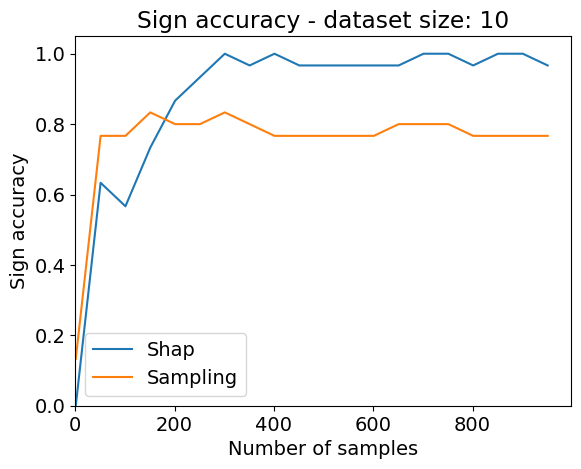

In [46]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure() 
plt.figure().clear()
plt.rcParams.update({'font.size': 14})
t = [i[0] for i in data_shap]
plt.plot(t,[i[1] for i in data_shap],label='Shap')
plt.plot(t,[i[1] for i in data_monte ],label='Sampling')
plt.title("Sign accuracy - dataset size: 10")
plt.xlabel("Number of samples")
plt.ylabel("Sign accuracy")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.legend()
plt.savefig("sign_accuracy_shap_10.png")
plt.show()



In [40]:
data_shap

[(1, 0.0),
 (51, 0.6333333333333333),
 (101, 0.5666666666666667),
 (151, 0.7333333333333333),
 (201, 0.8666666666666667),
 (251, 0.9333333333333333),
 (301, 1.0),
 (351, 0.9666666666666667),
 (401, 1.0),
 (451, 0.9666666666666667),
 (501, 0.9666666666666667),
 (551, 0.9666666666666667),
 (601, 0.9666666666666667),
 (651, 0.9666666666666667),
 (701, 1.0),
 (751, 1.0),
 (801, 0.9666666666666667),
 (851, 1.0),
 (901, 1.0),
 (951, 0.9666666666666667)]

In [45]:
random.randint(1,2)

1